In [127]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
import joblib # for saving the model


### Get the data

In [3]:
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [7]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Checking for missing values

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Let us see how many districts belong to each category

In [9]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Summary of the numerical attributes

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Calculate the histogram of the features

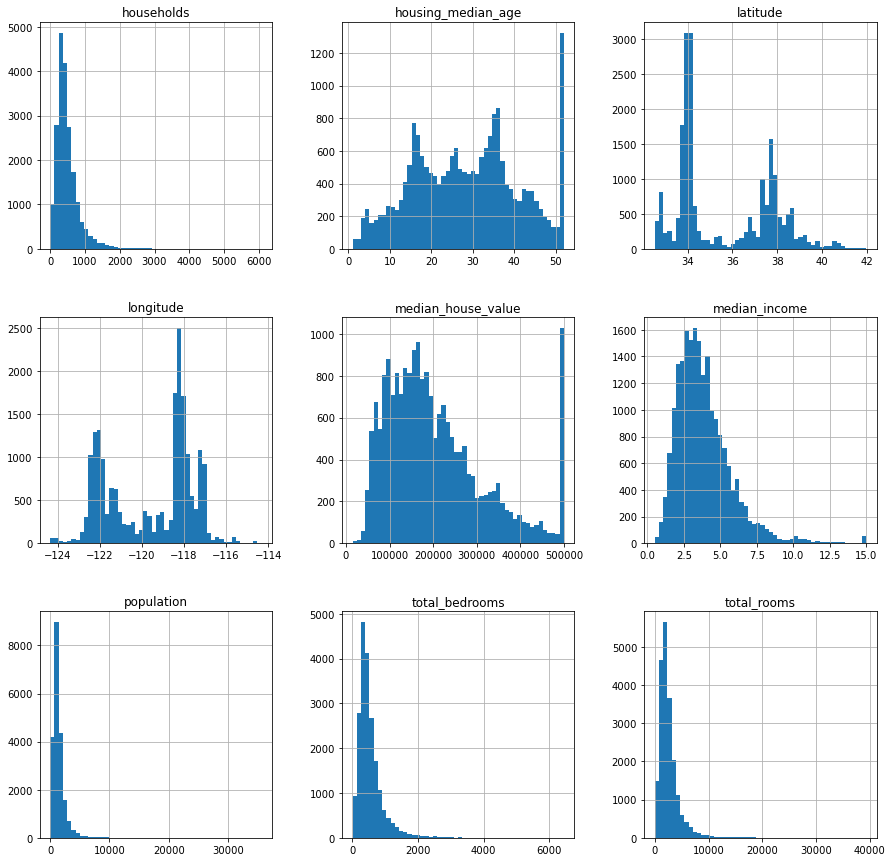

In [12]:
housing.hist(bins=50, figsize=(15,15))
plt.show()

* Median income does not express in US dollars. From the plot,lower value is around 0.5 and higher value is around 15.0. It should have been normalized with some scaling factor.
* More than 1000 households have the median housing value above 500K US dollars.
* These attributes are differently scaled. Feature scaling has to be done.
* Many histograms are tail heavy. It makes the ML algorithms harder to detect patterns.
* Plot shows the attributes only for numerical attributes.

### Splitting the data into train and test set

In [15]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print("The length of the train set: {}".format(len(train_set)))
print("The length of the test set: {}".format(len(test_set)))

The length of the train set: 16512
The length of the test set: 4128


In practical, the median income is one of the important features for buying the house. Let us dig deeper into the histogram of that one.

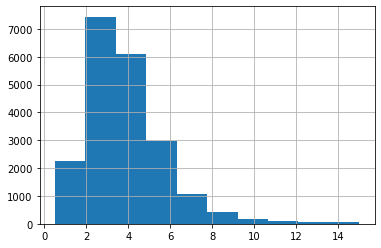

In [16]:
housing['median_income'].hist()

Most median income values are clustered around 1.5 to 6.0 and some of them are above 6.0. Let us make a categorical attribute called as "income_cat"

In [17]:
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf],
                              labels=[1, 2, 3, 4, 5])

In [18]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

### Histogram of median income categories

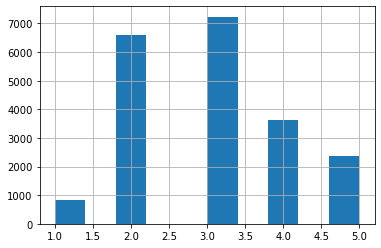

In [19]:
housing["income_cat"].hist()

### Stratified sampling based on the income_category

In [21]:
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(housing, housing['income_cat']):
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]

In [23]:
housing['income_cat'].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

### Sampling bias comparison with stratified sampling

In [24]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [25]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [27]:
# Remove the income_cat so the data back to to its original state
for set in (strat_train_set,strat_test_set):
    set.drop(['income_cat'],axis=1,inplace=True)

### Discover and Visualize the data to gain insights

In [28]:
# creating a copy of the training set 
housing_training=strat_train_set.copy()
housing_training.shape

(16512, 10)

### Visualizing the Geographical data based on lattitude and longitude

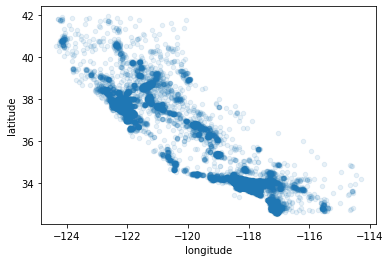

In [33]:
housing_training.plot(kind='scatter',x='longitude',y='latitude', alpha=0.1)

Better visualizations related with population and prices. The bigger a bubble leads to the higher the population of a district.

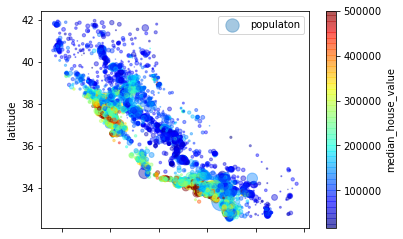

In [47]:
housing_training.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,
                     s=housing_training['population']/100,label='populaton',
                     c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True)
plt.legend()

The plot describes that red is expensive, blue is cheap and larger circle indicates the larger population of the district. It tells that the housing prices are related to the location and population density as we knew already.

### Looking for correlations

In [34]:
corr_matrix = housing.corr()

In [35]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Text(0.5, 1.0, 'Correlation Matrix')

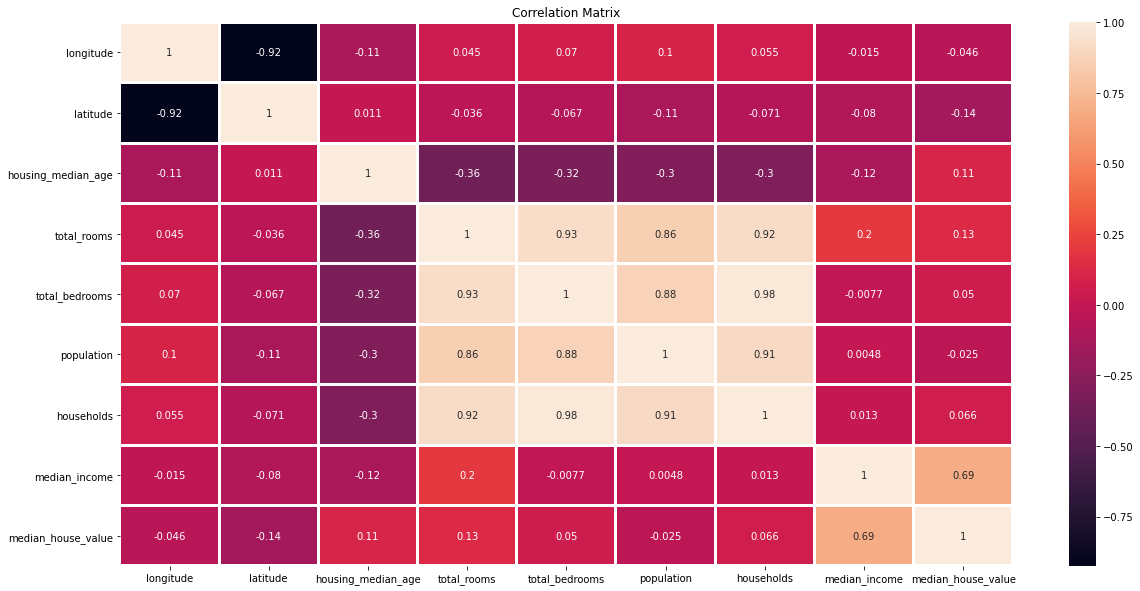

In [39]:
# attributes correlation
f,ax=plt.subplots(figsize=(20,10))
sns.heatmap(corr_matrix,linewidths=2.0,ax=ax,annot=True)
ax.set_title('Correlation Matrix')

The correlation coefficient is from -1 to 1. When it is close to 1, it means that strong positive correlation and when it is close to -1, it means that strong negative correlation.

### Scatter plot for the every numerical attribute against every other numerical attribute and their histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CD78792160>,
      dtype=object)

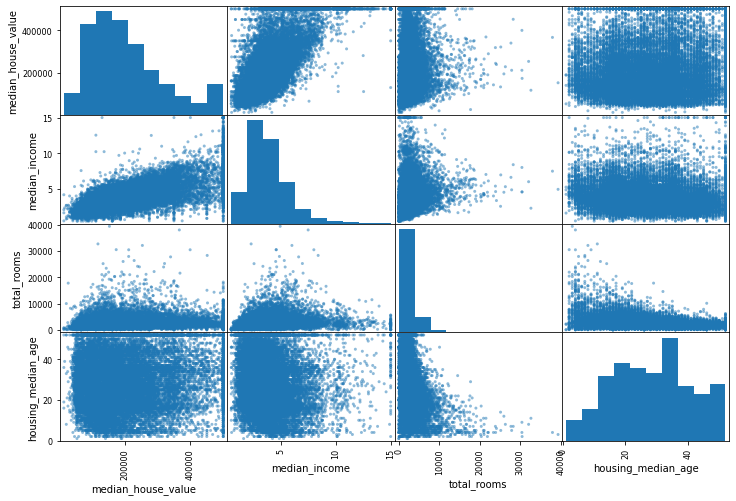

In [40]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

As we know that the most promising attribute is median income against median house value, we can see the upward trend clearly.

### Experiment with attribute combinations

In [41]:
housing_training['population_per_household']=housing_training['population']/housing_training['households']
housing_training['rooms_per_household']=housing_training['total_rooms']/housing_training['households']
housing_training['bedroom_per_rooms']=housing_training['total_bedrooms']/housing_training['total_rooms']

### Check the correlation matrix again

In [42]:
corr_matrix=housing_training.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedroom_per_rooms          -0.259984
Name: median_house_value, dtype: float64

The "bedroom_per_rooms" feature is much more correlated than the "total bed rooms" and "total rooms" with the "median house value"

In [43]:
housing_training.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,population_per_household,rooms_per_household,bedroom_per_rooms
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,3.096437,5.440341,0.212878
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,11.584826,2.611712,0.057379
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,0.692308,1.130435,0.100000
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,2.431287,4.442040,0.175304
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,2.817653,5.232284,0.203031
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,3.281420,6.056361,0.239831
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,1243.333333,141.909091,1.000000


### Preparing the data to feed them into machine learning algorithms

In [71]:
# Separate the training features and class labels
housing_train=strat_train_set.drop('median_house_value',axis=1)
housing_target=strat_train_set['median_house_value'].copy()

### Data Cleaning

In [73]:
imputer=SimpleImputer(strategy='median')
# Imputer is applicable for numerical attributes, so drop the text attributes
housing_num=housing_train.drop('ocean_proximity',axis=1)
imputer.fit(housing_num)
# Transform the training set
X=imputer.transform(housing_num)
housing_clean=pd.DataFrame(X,columns=housing_num.columns)

In [74]:
housing_clean.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,533.998123,1419.790819,497.060380,3.875589
std,2.001860,2.138058,12.574726,2138.458419,410.839621,1115.686241,375.720845,1.904950
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,296.000000,784.000000,279.000000,2.566775
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900
75%,-118.010000,37.720000,37.000000,3141.000000,641.000000,1719.250000,602.000000,4.744475
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


Let's preprocess the categorical input feature called as ocean_proximity

In [75]:
encoder=LabelEncoder()
housing_cat=housing_train['ocean_proximity']
housing_cat_int_encoded=encoder.fit_transform(housing_cat)
housing_cat_int_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [76]:
# convert the integer categorical values into one-hot vectors 
encoder=OneHotEncoder(sparse=False)
housing_cat_1hot=encoder.fit_transform(housing_cat_int_encoded.reshape(-1,1))
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### Custom Transformer to add the extra attributes

In [82]:
# column indices
room_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, x, y=None):
        return self
    def transform(self, x, y=None):
        rooms_per_household = x[:,room_ix] / x[:,household_ix]
        population_per_household = x[:,population_ix] / x[:,household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room=x[:,bedrooms_ix]/x[:,room_ix]
            return np.c_[x,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[x,rooms_per_household,population_per_household]
        
attr_adder=CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_xtra=attr_adder.transform(housing_train.values)
            

In [78]:
housing_xtra=pd.DataFrame(housing_xtra,columns=list(housing_train.columns)+['rooms_per_household','population_per_household'])
housing_xtra.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


### Build a Transformation Pipeline

In [83]:
num_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('attr_adder',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
])
housing_num_tr=num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [86]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing_train)
housing_prepared.shape

(16512, 16)

### Select and train a model

In [88]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_target) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let's try with few instances from the training set

In [91]:
some_data = housing_train.iloc[:5]
some_labels = housing_target.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


The predictions are not exactly accurate. Let's measure the root mean square error for this model using whole training set.

In [95]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_target, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

When there is an outlier in the dataset, the mean squared error will be higher so let's check with the mean absolute error.

In [97]:
lin_mae = mean_absolute_error(housing_target, housing_predictions)
lin_mae

49439.895990018966

It is clear that the model is underfitting the training set. It means that either the features does not provide enough information to make good predictions or the model is not powerful enough to learn from the data.

In [99]:
tree_reg=DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_target)

all_housing_predictions=tree_reg.predict(housing_prepared)
tree_mse=mean_squared_error(housing_target,all_housing_predictions)
tree_rmse=np.sqrt(tree_mse)
tree_rmse

0.0

Well, the model is badly overfitting with the training data. We should not use the test data to evaluate the model until finalized it. Therefore, we evaluate the model with the 10 fold cross validation technique.

### Evaluate using K-Fold Cross Validation

In [103]:
# Cross validation scores for the Decision Tree
scores=cross_val_score(tree_reg,housing_prepared,housing_target,
                      scoring='neg_mean_squared_error',cv=10)
# The scoring function is the opposite of the MSE(a neg value) that's why the
# -scores before calculating the square root.
tree_rmse_scores=np.sqrt(-scores)

In [104]:
def display_scores(scores):
    print('scores:',scores)
    print('mean:',scores.mean())
    print('standard_deviation:',scores.std())

display_scores(tree_rmse_scores)

scores: [69426.05602453 67835.61721902 70336.46031887 68576.43411618
 70057.89391106 76115.29404346 69469.89987418 71566.38548731
 76145.66917444 70114.00197861]
mean: 70964.37121476576
standard_deviation: 2752.645638592962


In [105]:
# Cross validation scores for the linear regression model
scores=cross_val_score(lin_reg,housing_prepared,housing_target,
                      scoring='neg_mean_squared_error',cv=10)
lin_reg_rmse_scores=np.sqrt(-scores)
display_scores(lin_reg_rmse_scores)

scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
mean: 69052.46136345083
standard_deviation: 2731.6740017983425


It's understandable from the cross-validation scores that the decision tree performs worse than linear regression model and it is overfitting with the training data.

In [107]:
# Try with the Random Forest Regressor
forest_reg=RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_target)

all_housing_predictions=forest_reg.predict(housing_prepared)
forest_mse=mean_squared_error(housing_target,all_housing_predictions)
forest_rmse=np.sqrt(forest_mse)
forest_rmse

18779.377938170062

In [108]:
scores=cross_val_score(forest_reg,housing_prepared,housing_target,
                      scoring='neg_mean_squared_error',cv=10)
forest_rmse_scores=np.sqrt(-scores)
display_scores(forest_rmse_scores)

scores: [49162.06039716 47569.70106151 49887.18392655 52547.9459219
 50096.53287174 53482.49334928 48937.65821217 48050.85758717
 52896.18675113 50132.36156991]
mean: 50276.29816485017
standard_deviation: 1944.7382050597876


In [109]:
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     50276.298165
std       2049.934060
min      47569.701062
25%      48993.758758
50%      49991.858399
75%      51944.049834
max      53482.493349
dtype: float64

### Finetuning the Model
From the above three models, random forest works better than others. Let us finetune the hyperparameters by using grid search and random search methods.

In [110]:
# Grid Search with Random Forest
param_grid=[
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]},
]
forest_reg=RandomForestRegressor()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search=GridSearchCV(forest_reg,param_grid,cv=5,
                        scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared,housing_target)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [111]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [112]:
# best score
mse=grid_search.best_score_
rmse=np.sqrt(-mse)
rmse

50056.02889572647

In [113]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [114]:
# Grid search results 
grid_results=grid_search.cv_results_
for mean_score,params in zip(grid_results['mean_test_score'],grid_results['params']):
    print(np.sqrt(-mean_score),params)

63245.46420481634 {'max_features': 2, 'n_estimators': 3}
55234.15213919878 {'max_features': 2, 'n_estimators': 10}
52757.5004904583 {'max_features': 2, 'n_estimators': 30}
60854.41271149839 {'max_features': 4, 'n_estimators': 3}
52698.073355644694 {'max_features': 4, 'n_estimators': 10}
50434.47649406027 {'max_features': 4, 'n_estimators': 30}
58820.194453182135 {'max_features': 6, 'n_estimators': 3}
51778.258550446124 {'max_features': 6, 'n_estimators': 10}
50123.94128114406 {'max_features': 6, 'n_estimators': 30}
58357.20220250187 {'max_features': 8, 'n_estimators': 3}
52337.642201104834 {'max_features': 8, 'n_estimators': 10}
50056.02889572647 {'max_features': 8, 'n_estimators': 30}
62834.32569187419 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54563.338453921286 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59829.01374342603 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52796.39919129208 {'bootstrap': False, 'max_features': 3, 'n_estimators'

The best score of the grid search approach gives better result than default values of the Random forest regressor.

In [116]:
# Random Search
param_rnd={
    'n_estimators':randint(low=1,high=200),
    'max_features':randint(low=1,high=8),
}
forest_reg=RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

rnd_search=RandomizedSearchCV(forest_reg,param_distributions=param_rnd,
                              n_iter=10,cv=5,scoring='neg_mean_squared_error',random_state=42)
rnd_search.fit(housing_prepared,housing_target)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [117]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [118]:
rnd_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=180, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [119]:
# Random search results
rnd_results=rnd_search.cv_results_
for mean_score,params in zip(rnd_results['mean_test_score'],rnd_results['params']):
    print(np.sqrt(-mean_score),params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


The RMSE value of the random search(best score) is 49150.70 whereas the grid search method(best score) gives 50056.02. In this case, the random search works better than Grid search for finding out the best hyperparameters of the Random Forest Regressor.

In [122]:
# the importance of each feature in the grid search result
feature_importances=grid_search.best_estimator_.feature_importances_
feature_importances

array([7.50056063e-02, 6.54854719e-02, 4.28863152e-02, 1.56269703e-02,
       1.42181932e-02, 1.52671154e-02, 1.43855197e-02, 3.51199668e-01,
       4.49030627e-02, 1.09907810e-01, 7.65089184e-02, 1.04979751e-02,
       1.59540091e-01, 3.41246511e-05, 1.71971823e-03, 2.81343977e-03])

In [123]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.35119966823088283, 'median_income'),
 (0.15954009066202965, 'INLAND'),
 (0.10990781035187955, 'pop_per_hhold'),
 (0.07650891843129465, 'bedrooms_per_room'),
 (0.07500560625052272, 'longitude'),
 (0.06548547188419382, 'latitude'),
 (0.04490306270109062, 'rooms_per_hhold'),
 (0.0428863151566712, 'housing_median_age'),
 (0.015626970294485402, 'total_rooms'),
 (0.015267115441362077, 'population'),
 (0.014385519708279821, 'households'),
 (0.014218193168053412, 'total_bedrooms'),
 (0.010497975066262858, '<1H OCEAN'),
 (0.0028134397677726706, 'NEAR OCEAN'),
 (0.0017197182341533962, 'NEAR BAY'),
 (3.412465106544453e-05, 'ISLAND')]

### Evaluate the system on the test set

In [124]:
# using finetuned Grid Search model
final_model_grid=grid_search.best_estimator_

x_test=strat_test_set.drop('median_house_value',axis=1)
y_test=strat_test_set['median_house_value'].copy()

x_test_prepared=full_pipeline.transform(x_test)
final_predictions=final_model_grid.predict(x_test_prepared)

final_mse=mean_squared_error(y_test,final_predictions)
final_rmse=np.sqrt(final_mse)
final_rmse

47876.99987544171

In [125]:
# using finetuned random search model
final_model_rnd=rnd_search.best_estimator_

x_test=strat_test_set.drop('median_house_value',axis=1)
y_test=strat_test_set['median_house_value'].copy()

x_test_prepared=full_pipeline.transform(x_test)
final_predictions=final_model_rnd.predict(x_test_prepared)

final_mse=mean_squared_error(y_test,final_predictions)
final_rmse=np.sqrt(final_mse)
final_rmse

46910.92117024934

## Save the model

In [133]:
joblib.dump(final_model_grid,'models/final_model_grid.pkl')

['models/final_model_grid.pkl']

In [132]:
joblib.dump(final_model_rnd,'models/final_model_random.pkl')

['models/final_model_random.pkl']

### Loading the model

In [135]:
rf_grid_model = joblib.load("models/final_model_grid.pkl")
rf_grid_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)